In [6]:
import pyfolio as pf
# This is a sample Python script.
from datetime import datetime
import time

# from src.pairs.pairs_strategy import TradingPair
import yfinance as yf

from src.pairs.pair_strategy import PairStrategy
from src.pairs.coint_functions import *

from src.pairs.portfolio import Portfolio


from src.util.DataFetcher import *

import pandas as pd
import statsmodels.api as sm

from statsmodels.tools.tools import add_constant

import numpy as np


import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Load your data
# For this example, assume 'data' is a DataFrame with two columns: 'asset1' and 'asset2'
# data = pd.read_csv('path_to_your_data.csv')


# Backtest and risk management code would go here



### Explanation
1. **Hedge Ratio Calculation**: The Kalman Filter is used to dynamically calculate the hedge ratio between the two assets.
2. **Signal Generation**: Trading signals are generated based on the calculated spread.
3. **Trading Logic**: The script simulates buying and selling the assets based on the signals. It tracks the position sizes and the capital.
4. **Portfolio Value Tracking**: The script keeps a record of the portfolio's value over time.
5. **Performance Metrics**: Calculates and prints key performance metrics such as total return, CAGR, volatility, and the Sharpe ratio.

### Important Considerations
- **Data Quality**: Ensure the historical data is accurate and representative of market conditions.
- **Transaction Costs**: Include realistic costs for a more accurate backtest.
- **Risk Management**: Implement risk management measures like stop-losses.
- **Regulatory Compliance**: Ensure your strategy complies with all financial regulations.

Remember, this is a simplified example for educational purposes. Real-world trading strategies require comprehensive testing, risk management, and adherence to regulatory standards.


In [4]:
pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48444 sha256=05d1bf619b9b47fc6c3f34f17bdefaaae02becedecbccbd0f88370f51ab19fc8
  Stored in directory: /Users/georgelyons/Library/Caches/pip/wheels/95/da/a9/45e35fe223d67e4d58e97f78c1a32d7ce36e733add3ce4c126
Successfully built pykalman

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# tickers = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT", "GS", "XOM", "META", "BRK-B", "MSFT", "QQQ"]
tickers = ["BTC-USD", "ETH-USD"]
# tickers = ["MSFT", "QQQ"]

start_date = datetime(2017, 1, 1)
end_date = datetime(2024, 1, 27)
tickData = get_all_adjusted_close_data(start_date, end_date, tickers)

tickData


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,BTC-USD,ETH-USD
Date,,
2017-01-01,998.325012,NaN
2017-01-02,1021.750000,NaN
2017-01-03,1043.839966,NaN
2017-01-04,1154.729980,NaN
2017-01-05,1013.380005,NaN
...,...,...
2024-01-09,46139.730469,2344.827148
2024-01-10,46627.777344,2582.103516
2024-01-11,46368.585938,2619.619141


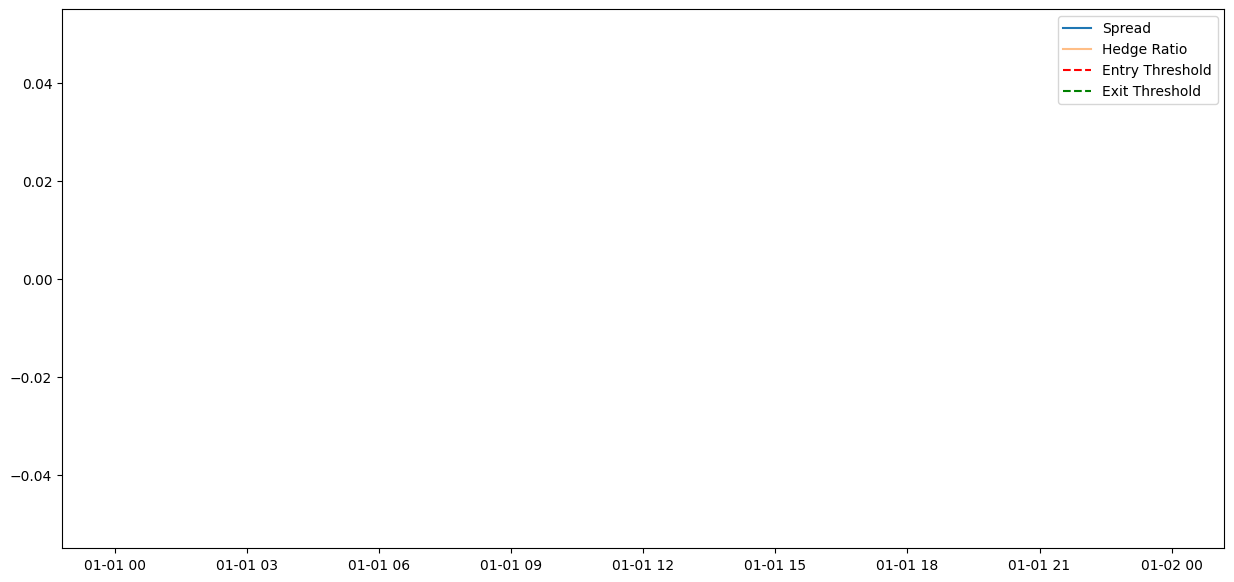

In [9]:
import warnings
warnings.filterwarnings('ignore')


# Initialize the Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

# Use the Kalman Filter to estimate the hedge ratio
state_means, _ = kf.filter(tickData['BTC-USD'].values / tickData['ETH-USD'].values)
hedge_ratio = state_means.flatten()

# Construct the spread
spread = tickData['BTC-USD'] - hedge_ratio * tickData['ETH-USD']

# Define entry and exit thresholds
entry_threshold = spread.mean() + 0.5 * spread.std()
entry_threshold = spread.mean() + 0.5 * spread.std()
exit_threshold = spread.mean()

# Generate trading signals
positions = np.where(spread > entry_threshold, -1, np.nan)  # Short the spread
positions = np.where(spread < exit_threshold, 1, positions)  # Long the spread
positions = np.where(np.isnan(positions), 0, positions)     # Flatten

# Plot the spread and signals
plt.figure(figsize=(15,7))
plt.plot(spread, label='Spread')
plt.plot(hedge_ratio, label='Hedge Ratio', alpha=0.5)
plt.axhline(entry_threshold, color='red', linestyle='--', label='Entry Threshold')
plt.axhline(exit_threshold, color='green', linestyle='--', label='Exit Threshold')
plt.legend()
plt.show()


# pair = PairStrategy(tickData['BTC-USD'],tickData['ETH-USD'],'2018-01-05','2019-01-04','2018-01-05','2019-01-04')

# print(pair.is_valid_pair)
# val = pair.run_strategy(z=1)
# pair.plot_pair(pair.results)



# pf.create_simple_tear_sheet(pair.results['strategy'])

# pair.results




Start date,2018-01-05
End date,2019-01-04
Total months,17
,Backtest
Annual return,27.044%
Cumulative returns,41.438%
Annual volatility,29.258%
Sharpe ratio,0.96
Calmar ratio,0.98
Stability,0.62
Max drawdown,-27.461%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.46,2018-01-27,2018-02-05,2018-03-08,29
1,17.28,2018-12-20,2019-01-04,NaT,NaN
2,7.43,2018-08-31,2018-09-12,2018-11-14,54
3,7.35,2018-11-17,2018-12-15,2018-12-20,24
4,5.71,2018-06-18,2018-06-22,2018-06-30,10


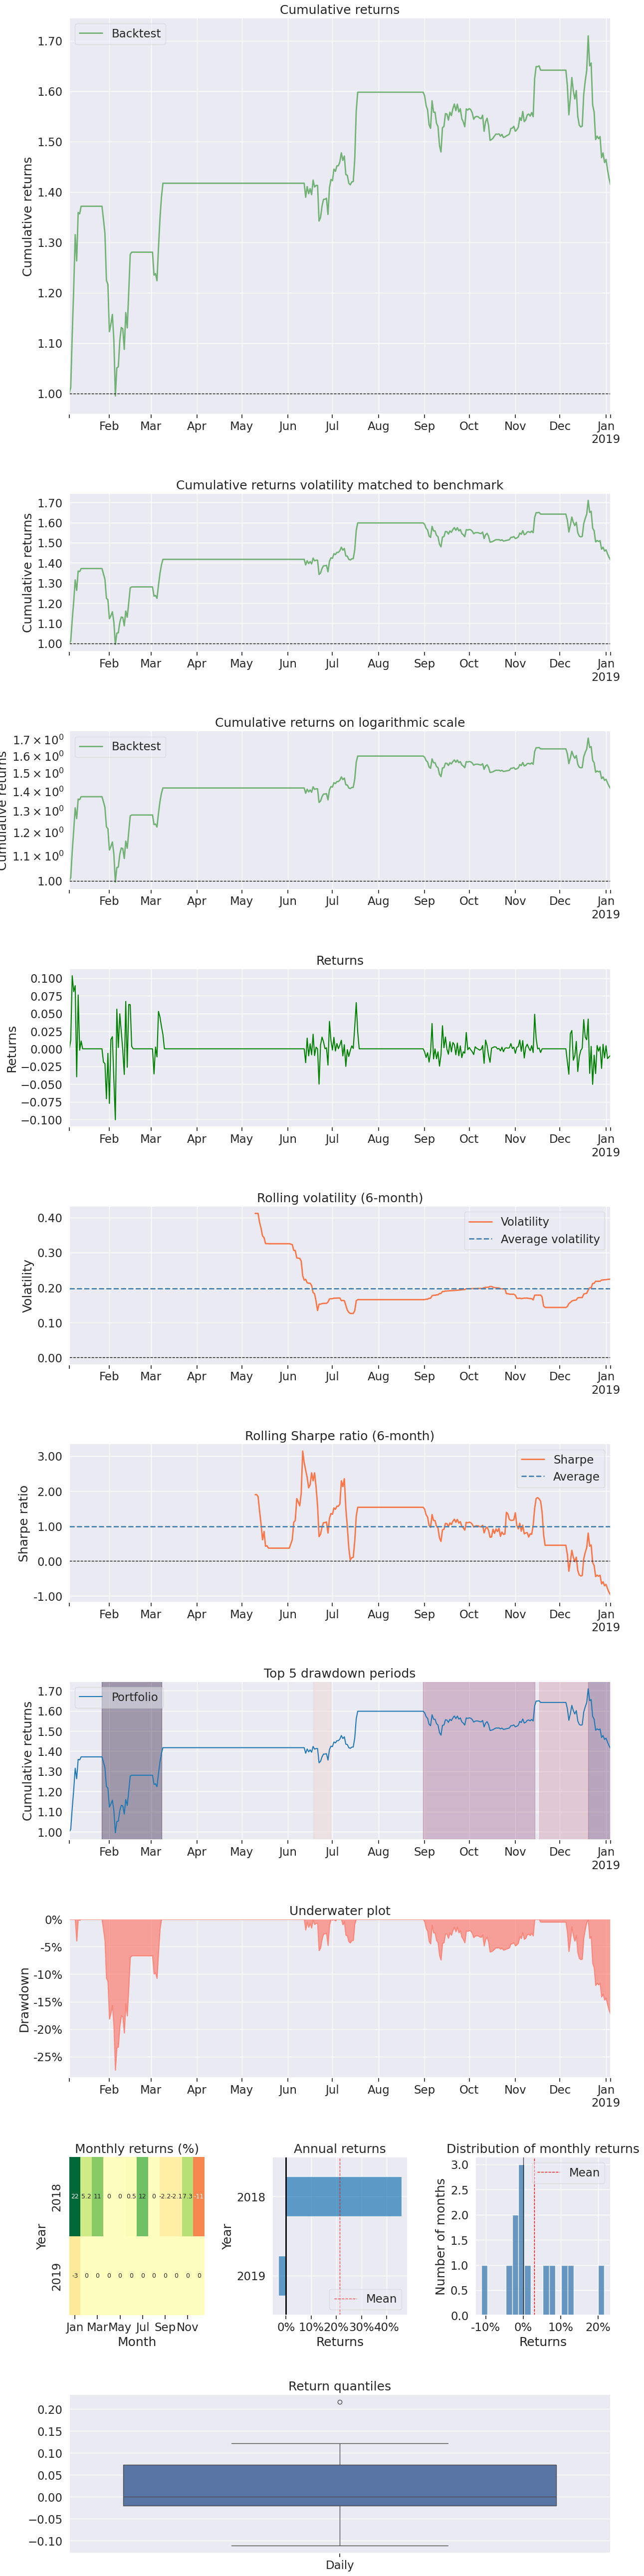

In [90]:
#just compare this with other model - if it matches then good!!!
pf.create_full_tear_sheet(pair.results['strategy'])

Positions head:
 Date
2018-01-01   -1.0
2018-01-02   -1.0
2018-01-03   -1.0
2018-01-04   -1.0
2018-01-05   -1.0
Name: position, dtype: float64
Asset1 returns head:
 Date
2018-01-01         NaN
2018-01-02    0.144702
2018-01-03    0.088503
2018-01-04    0.018907
2018-01-05    0.017125
Name: ETH-USD, dtype: float64
Asset2 returns head:
 Date
2018-01-01         NaN
2018-01-02    0.097011
2018-01-03    0.014611
2018-01-04    0.026196
2018-01-05    0.117333
Name: BTC-USD, dtype: float64
Strategy returns head:
             2018-01-01 00:00:00  2018-01-02 00:00:00  2018-01-03 00:00:00  \
Date                                                                        
2018-01-01                  NaN                  NaN                  NaN   
2018-01-02                  NaN                  NaN                  NaN   
2018-01-03                  NaN                  NaN                  NaN   
2018-01-04                  NaN                  NaN                  NaN   
2018-01-05                 

<Axes: xlabel='Date'>

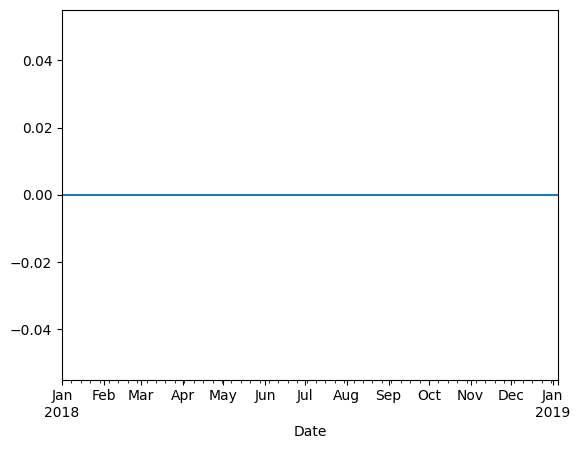

In [17]:
position = pair.results['position']

daily_returns = compute_strategy_returns(positions=position, asset1=pair.x_full, asset2=pair.y_full)
daily_returns.plot()

In [7]:
pair.results.head(100)

,price_y,price_x,full_resid,b,return_y,return_x,return,mu,dist,lower_bound,upper_bound,position,strategy,creturns,cstrategy
Date,,,,,,,,,,,,,,,
2018-01-05,1.0000,1.0000,0.3573,0.4113,0.0000,0.0000,0.0000,-0.002326,0.359626,-0.060228,0.055576,-1.0,0.0000,1.000000,1.000000
2018-01-06,1.0056,1.0441,0.3448,0.4113,0.0056,0.0431,-0.0122,-0.002326,0.347126,-0.060228,0.055576,-1.0,0.0122,0.987874,1.012275
2018-01-07,0.9454,1.1558,0.2386,0.4113,-0.0617,0.1017,-0.1036,-0.002326,0.240926,-0.060228,0.055576,-1.0,0.1036,0.890653,1.122771
2018-01-08,0.8704,1.1512,0.1655,0.4113,-0.0827,-0.0040,-0.0810,-0.002326,0.167826,-0.060228,0.055576,-1.0,0.0810,0.821355,1.217501
2018-01-09,0.8374,1.3027,0.0702,0.4113,-0.0386,0.1237,-0.0895,-0.002326,0.072526,-0.060228,0.055576,-1.0,0.0895,0.751037,1.331492
2018-01-10,0.8591,1.2587,0.1100,0.4113,0.0256,-0.0344,0.0397,-0.002326,0.112326,-0.060228,0.055576,-1.0,-0.0397,0.781453,1.279667
2018-01-11,0.7691,1.1576,0.0616,0.4113,-0.1106,-0.0837,-0.0761,-0.002326,0.063926,-0.060228,0.055576,-1.0,0.0761,0.724191,1.380851
2018-01-12,0.8021,1.2761,0.0458,0.4113,0.0420,0.0975,0.0019,-0.002326,0.048126,-0.060228,0.055576,-1.0,-0.0019,0.725568,1.378230
2018-01-13,0.8239,1.3996,0.0168,0.4113,0.0268,0.0924,-0.0112,-0.002326,0.019126,-0.060228,0.055576,-1.0,0.0112,0.717487,1.393753



Pyfolio, a Python library for performance and risk analysis of financial portfolios, primarily expects returns as input in the form of simple returns, not log returns. This is because most of Pyfolio's functions and metrics are designed to work with simple returns. However, it's relatively straightforward to convert log returns to simple returns if you have your data in log returns format.

In [7]:
import pyfolio as pf
import pandas as pd
import numpy as np
import yfinance as yf

# Load historical data for a stock (e.g., Apple Inc.)
stock_data = yf.download('QQQ', start='2019-01-01', end='2021-12-31')

# Calculate daily returns
stock_data['returns'] = stock_data['Adj Close'].pct_change()


# ret_log = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1)).fillna(0)

# Assume a simple buy and hold strategy
strategy_returns = stock_data['returns']
# strategy_returns
# ret_log
# # Create a benchmark (e.g., S&P 500)
# benchmark_data = yf.download('^GSPC', start='2019-01-01', end='2021-12-31')
# benchmark_returns = benchmark_data['Adj Close'].pct_change()

# # Create a tear sheet for the strategy
# strategy_returns
# pf.create_simple_tear_sheet(pair.results['net_strategy'])

[*********************100%%**********************]  1 of 1 completed
